# Constant Interval

We will choose a fixed parameter a > 0 for this strategy. In the beginning, we will provide liquidity in a symmetric interval around the current price. This interval will never be adjusted. More specifically, we will choose the interval [p − a, p + a], where p is the price at the beginning.
For the USDC-ETH pool, we will choose a ∈ [10, 40000], which means that the size is between 10 and 40000 basis points, or 0.1% and 400%. It does not make sense to choose another a because, at any time, the price is always in [p−a,p+a].

Import code dependencies

In [47]:
from typing import List

import pandas as pd
from matplotlib.pylab import plt
import matplotlib.dates as mdates

from demeter import MarketInfo
from demeter.broker import AccountStatus
from demeter.result import performance_metrics

Set matplotlib to show formatted account status

In [48]:
def plotter(account_status_list: List[AccountStatus]):
    net_value_ts = [status.net_value for status in account_status_list]
    time_ts = [status.timestamp for status in account_status_list]
    plt.plot(time_ts, net_value_ts)
    plt.show()

Make plot about price and account value / position net value

In [49]:
def plot_position_return_decomposition(account_status: pd.DataFrame, price: pd.Series, market: MarketInfo):
    fig, value_ax = plt.subplots()
    day = mdates.DayLocator(interval=2)

    price_ax = value_ax.twinx()
    price_ax.xaxis.set_major_locator(day)
    price_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    value_ax.set_xlabel('time')
    value_ax.set_ylabel('value', color='g')
    price_ax.set_ylabel('price', color='b')

    net_value_ts = list(account_status.net_value)
    time_ts = list(account_status.index)
    price_ts = list(price)

    value_in_position = account_status[market.name]["net_value"]
    value_in_account = account_status["tokens"]["USDC"] + account_status["tokens"]["ETH"] * price

    value_ax.plot(time_ts, net_value_ts, 'g-', label="net value")
    value_ax.plot(time_ts, value_in_position, 'r-', label="value in get_position")
    value_ax.plot(time_ts, value_in_account, 'b-', label="value in broker account")
    price_ax.plot(time_ts, price_ts, 'y-', label="price")
    fig.legend()
    fig.show()

Add dependence about run Actuator

In [50]:
from datetime import date
import pandas as pd
from demeter import Actuator, MarketInfo, TokenInfo, Strategy, ChainType
from demeter.uniswap import UniV3Pool, UniLpMarket

Set pandas output format

In [51]:
pd.options.display.max_columns = None
pd.set_option("display.width", 5000)

Custom Constant Interval strategy with code to add liquidity at constant interval around current price.

In [52]:
class ConstantIntervalStrategy(Strategy):
    def __init__(self, a=100):
        super().__init__()
        self.a = a

    def initialize(self):
        market: UniLpMarket = self.markets[market_key]
        init_price = market.market_status.data.price
        market.even_rebalance(init_price)  # rebalance all reserve token#
        # new_position(self, baseToken, quoteToken, usd_price_a, usd_price_b):
        # what is  base/quote "https://corporatefinanceinstitute.com/resources/knowledge/economics/currency-pair/"
        market.add_liquidity(init_price - self.a, init_price + self.a)
        super().__init__()

Main logic to run Actuator, init two token and market with key "market1"

In [53]:
usdc = TokenInfo(name="usdc", decimal=6)  # declare  token0
eth = TokenInfo(name="eth", decimal=18)  # declare token1
pool = UniV3Pool(usdc, eth, 0.05, usdc)  # declare pool
market_key = MarketInfo("market1")

actuator = Actuator()  # declare actuator
broker = actuator.broker
market = UniLpMarket(market_key, pool)

broker.add_market(market)
broker.set_balance(usdc, 2000)
broker.set_balance(eth, 0)

actuator.strategy = ConstantIntervalStrategy(200)

market.data_path = "../data"
market.load_data(ChainType.polygon.name, "0x45dda9cb7c25131df268515131f647d726f50608", date(2023, 8, 13),
                 date(2023, 8, 17))
actuator.set_price(market.get_price_from_data())
# actuator.run()  # run test

2024-07-22 16:21:14,195 - INFO - start load files from 2023-08-13 to 2023-08-17...
2024-07-22 16:21:14,252 - INFO - load file complete, preparing...
2024-07-22 16:21:14,477 - INFO - data has been prepared


Run actuator with evaluators and save result to files

In [54]:
actuator.run()
print({k: round(v, 5) for k, v in performance_metrics(
    actuator.account_status_df["net_value"], benchmark=actuator.account_status_df["price"]["ETH"]
).items()})

actuator.save_result(
    path="./result",  # save path
    account=True,  # save account status list as a csv file
    actions=True,  # save actions as a json file and a pickle file
)

2024-07-22 16:21:14,507 - INFO - init strategy...
2024-07-22 16:21:14,510 - INFO - start main loop...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 7200/7200 [00:02<00:00, 3011.37it/s]
2024-07-22 16:21:16,906 - INFO - main loop finished
2024-07-22 16:21:17,056 - INFO - Print actuator summary
2024-07-22 16:21:17,260 - INFO - Backtesting finished, execute time 2.754091262817383s


Final account status                              
Token balance in broker       
USDC      :0                        ETH       :0.053866916              
Position value in markets     
market1(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee(%)    :0.0500                   quote token:USDC                     
positions 
   lower_tick  upper_tick   pending0      pending1        liquidity
0      200073      202246  3.0201204  0.0019881852  417968653597863

Account balance history                           
l1                  net_value tokens               market1                                                                                          price     
l2                              USDC         ETH net_value base_uncollected quote_uncollected base_in_position quote_in_position position_count       ETH USDC
2023-08-13 00:00:00    1999.5      0 0.053866915 1899.9473    9.3205287e-08                 0       0.48708698         999.74982  

2024-07-22 16:21:17,364 - INFO - files have saved to ./result\backtest-20240722-162117.account.csv,./result\backtest-20240722-162117.action.json,./result\backtest-20240722-162117.action.pkl


{Return: Decimal('-119.84080'), Rate of Return: Decimal('-0.05994'), Annualized Return: Decimal('-0.98902'), Max Draw Down: Decimal('0.11184'), Sharpe Ratio: Decimal('-10.81064'), Volatility: Decimal('228.00872'), alpha: Decimal('0.00000'), beta: Decimal('0.90025')}


['./result\\backtest-20240722-162117.account.csv',
 './result\\backtest-20240722-162117.action.json',
 './result\\backtest-20240722-162117.action.pkl']

C:\Users\sun\AppData\Local\Temp\ipykernel_13440\3991704275.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


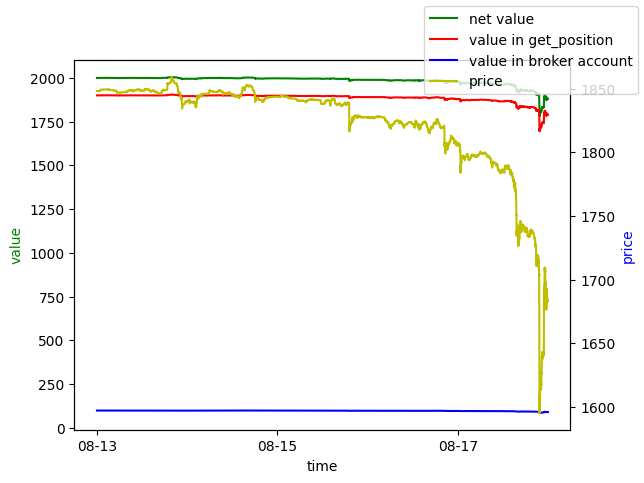

In [55]:
plot_position_return_decomposition(actuator.account_status_df, actuator.token_prices[eth.name], market_key)